In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, October 28th, 2024 at 11:59pm**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W1/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W1/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from IPython.display import HTML

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

1. _The topic chosen was Option 1, Default of Credit Card Clients._
2. _I think that this problem definitely has a lot of potential for bias. The data is unbalanced. There are more women over men so the might try to draw conclusions based on `sex` which shouldn't be the case. Age is also unbalanced so the model might not have enough data to make accurate predictions for people of higher age than lower age. Reducing such bias must be considered when building the model._

In [4]:
df = pd.read_csv("UCI_Credit_Card.csv")
df[["EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]] = df[["EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].astype(str)
df = df.drop(columns = ["ID"])
df.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [5]:
#remove rows with unknown values.
# BEGIN SOLUTION
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(21000, 24)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

1. _Check below code_
2. - _Looking at the `SEX` histogram, the dataset is unbalanced because there are more males than females so careful consideration must be made when buiding the model_
   - _Looking at the individual histogram comparisons of each feature, there is not much difference between people who will or won't make their monthly payments; therefore it is important to choose a model that combines the feature_
   - _The ranges of pay and bill statements vary and may have to be potentially scaled when using certain models._
   - _The mean of the pay and bill statements are also centered at different points and therefore will have to be scaled when using certain models_
3. As stated above, the data is not balanced and evaluation will have to look at more than just the accuracy of the dataset. There will have to be preprocessing due to different scales but imputation is not needed because there are no NA values. The individual features don't tell much about probability of making or not making monthly payments so therefore combinations of features will have to be used.
4. Since the dataset is unbalanced macro-average F1-Score will be used.
5. Code has unaccounted categories.... i will use interpretations found in the forum

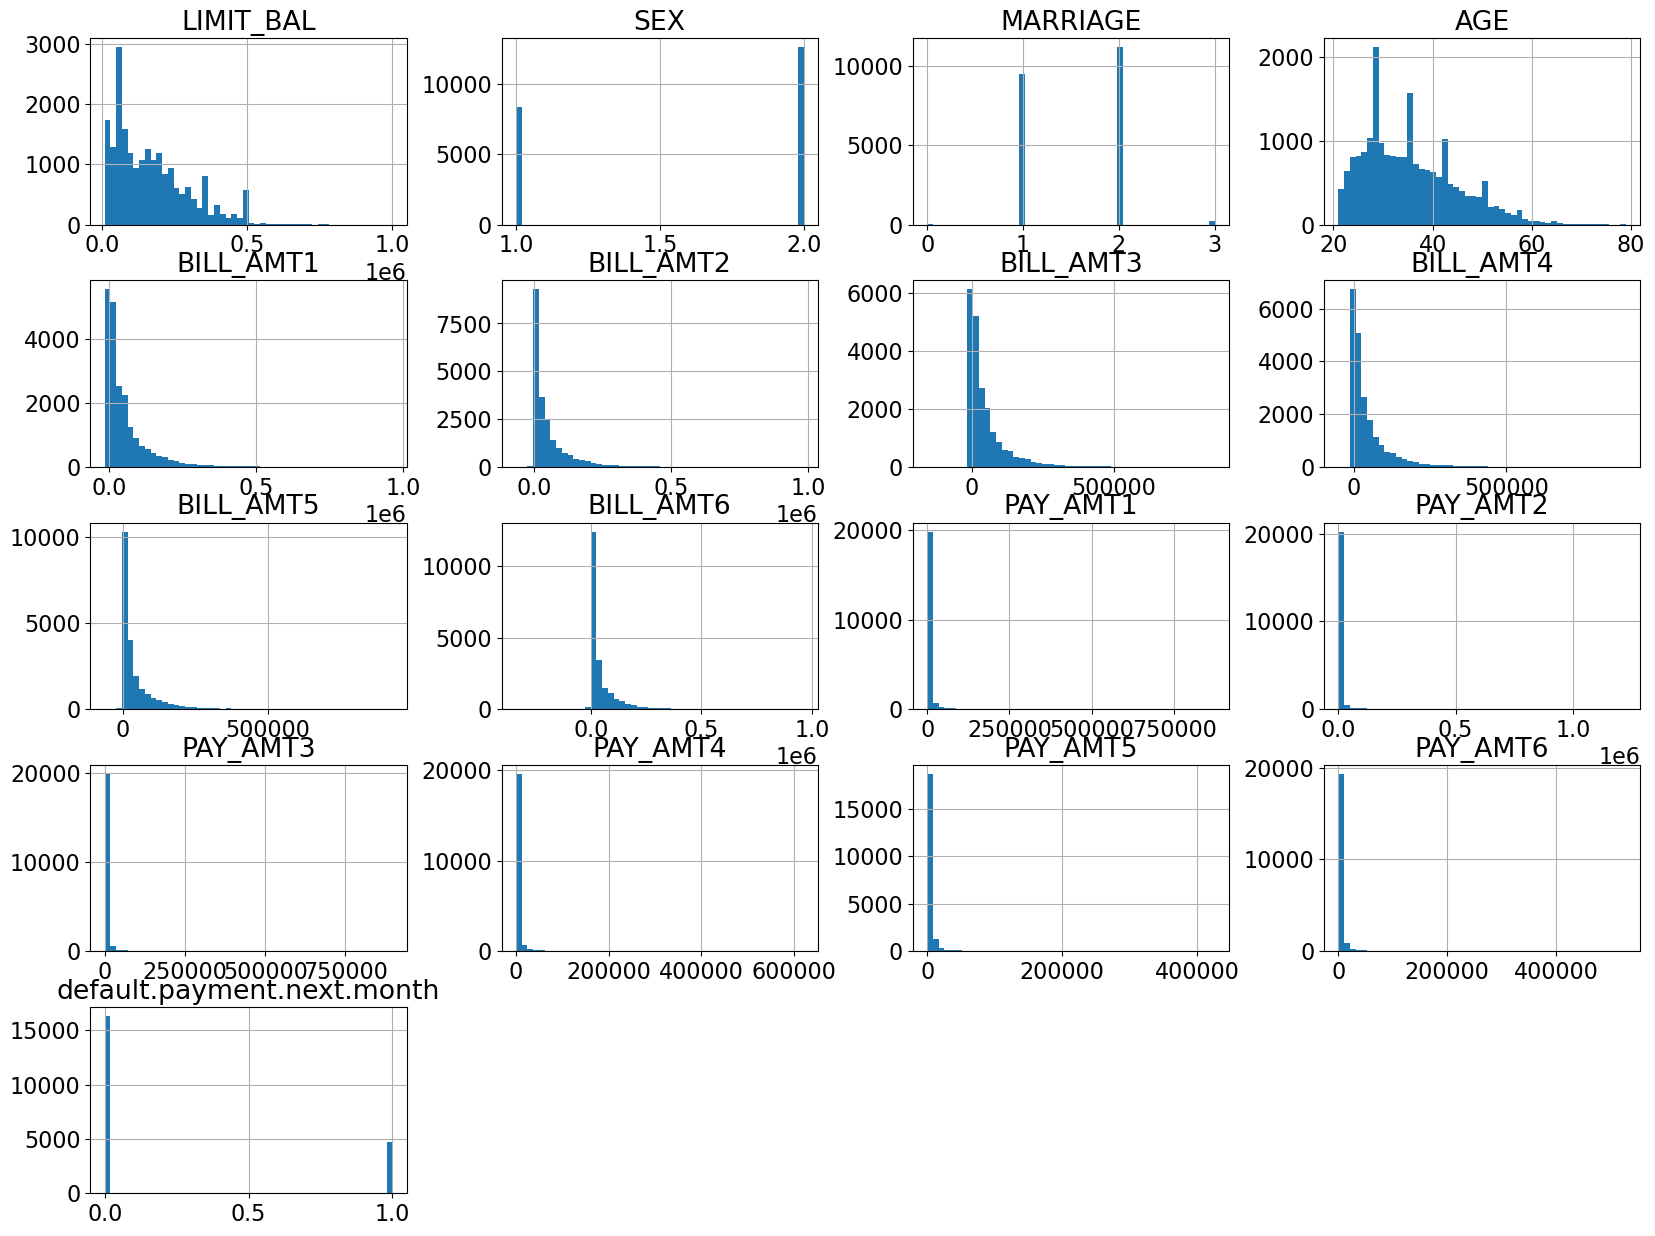

In [6]:
train_df.hist(bins=50, figsize=(20, 15));

In [7]:
train_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
16395,320000.0,2,1,2,36,0,0,0,0,0,...,19370.0,10155.0,3788.0,5000.0,5018.0,1000.0,3000.0,0.0,7013.0,0
21448,440000.0,2,1,2,30,-1,-1,-1,0,0,...,171244.0,150897.0,117870.0,612.0,87426.0,130007.0,3018.0,15000.0,51663.0,0
20034,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,-18.0,-18.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,0
25755,120000.0,2,2,1,30,0,0,0,0,0,...,103058.0,71095.0,47379.0,3706.0,5502.0,4204.0,3017.0,2005.0,1702.0,0
1438,50000.0,1,2,2,54,1,2,0,0,0,...,27585.0,27910.0,27380.0,0.0,1400.0,1200.0,1500.0,1000.0,1500.0,0


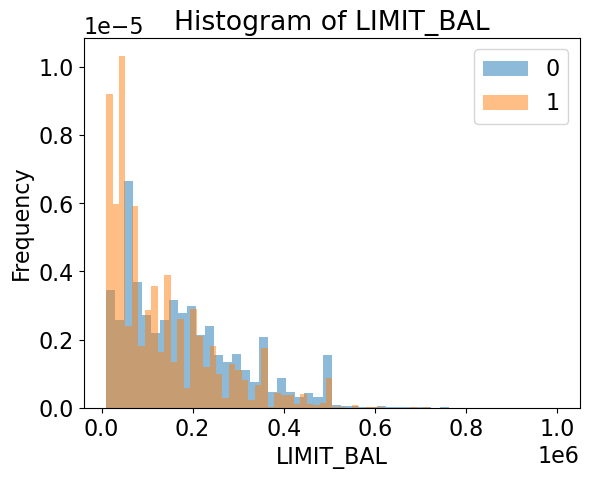

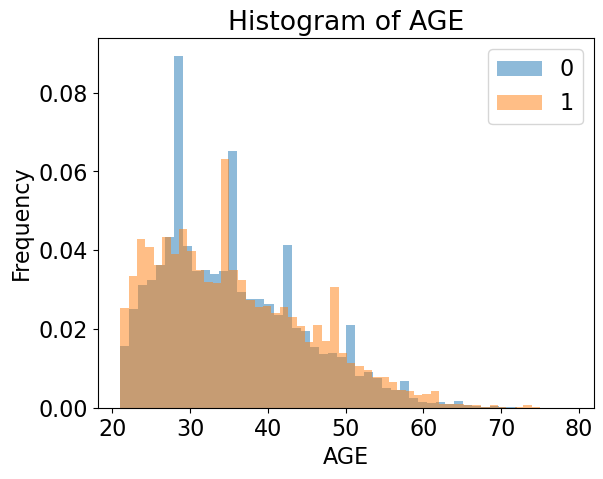

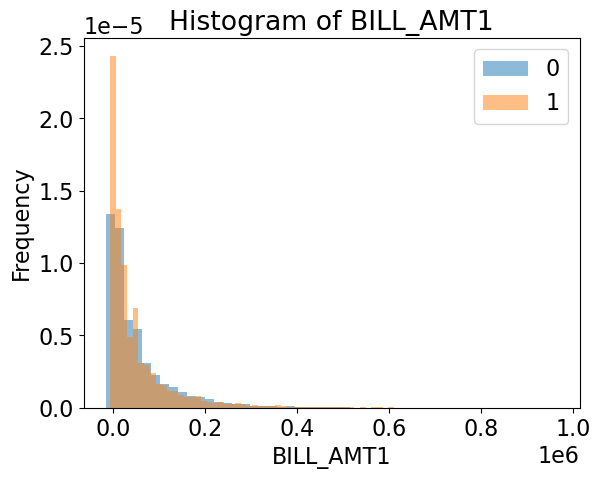

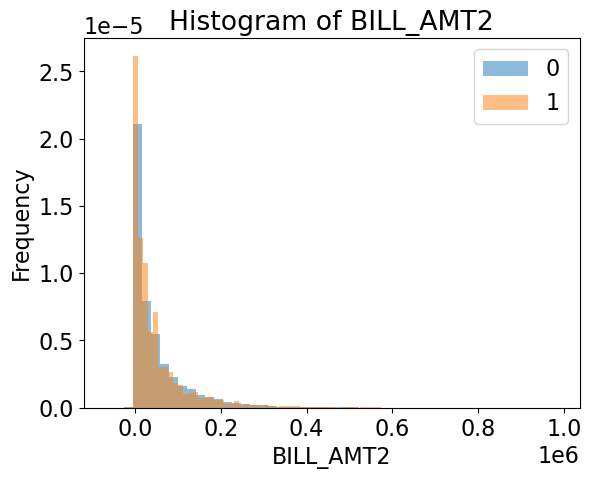

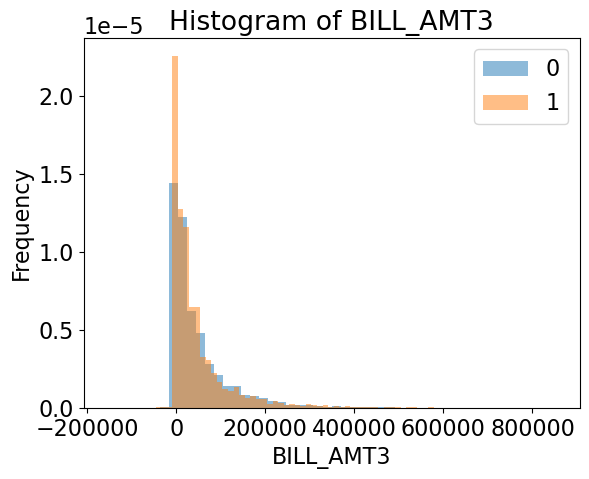

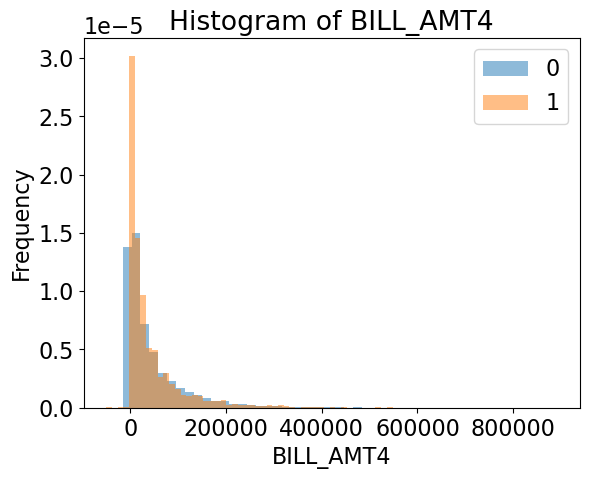

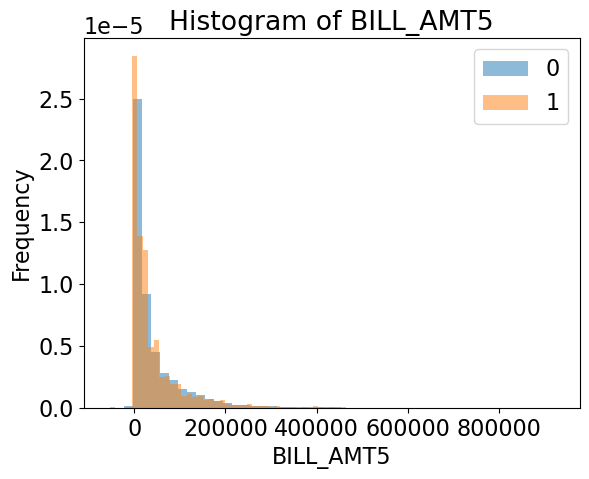

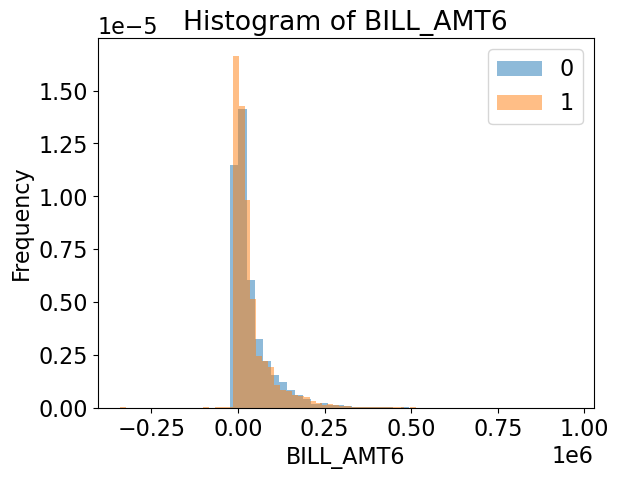

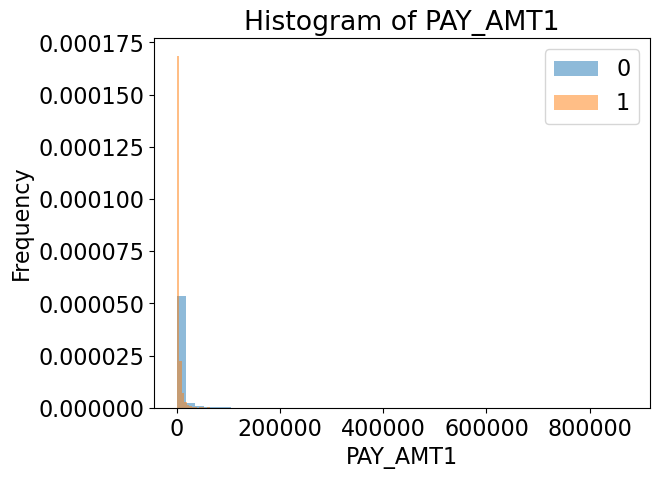

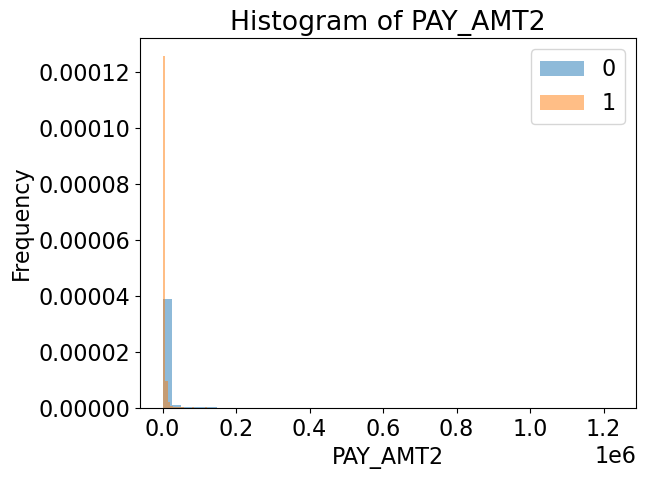

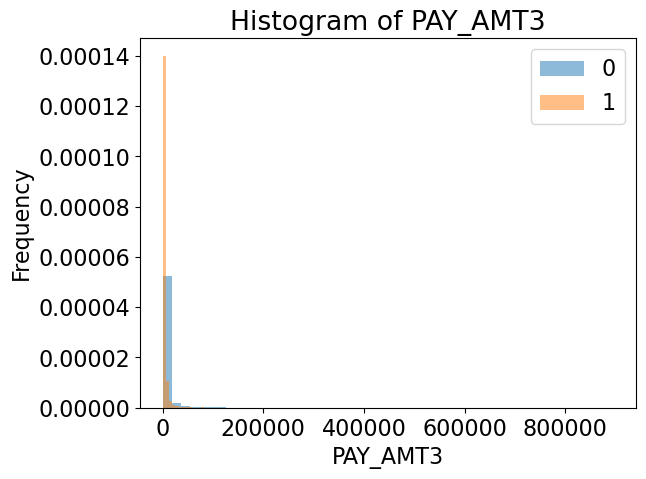

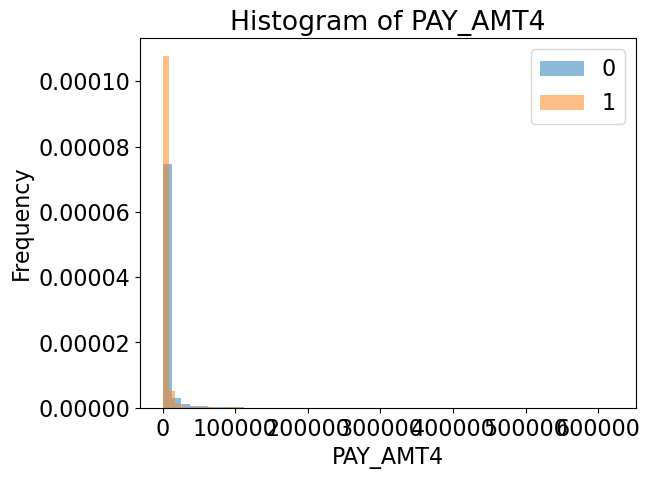

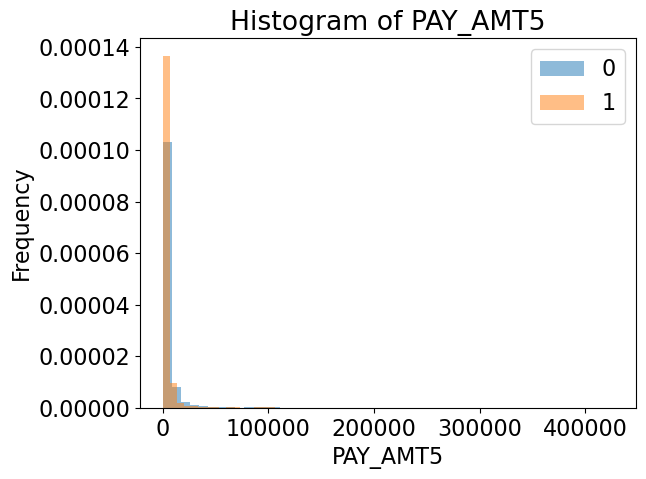

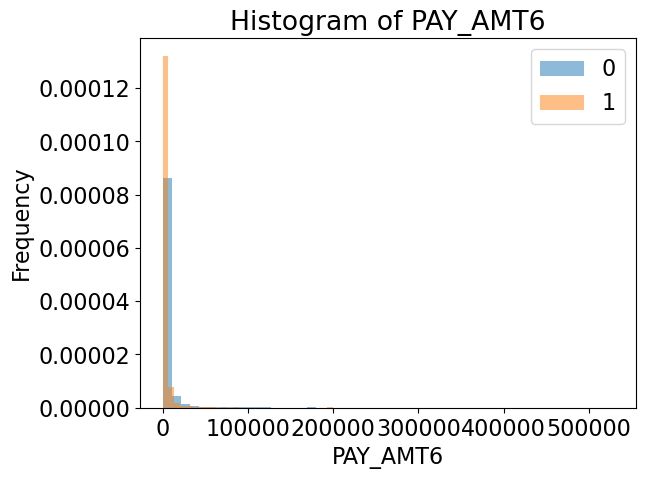

In [8]:
features = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "BILL_AMT1", 
            "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6","PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", 
                    "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for feat in numeric_features:
    train_df.groupby("default.payment.next.month")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
    plt.xlabel(feat);
    plt.show()
    

In [9]:
#Summary Statistics: Mean, Median, Standard Deviation, Range
df_desc = df.describe().T
df_desc["Range"] = df_desc["max"] - df_desc["min"]
df_desc.T

,LIMIT_BAL,SEX,MARRIAGE,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.551867,35.485500,5.122333e+04,4.917908e+04,4.701315e+04,4.326295e+04,4.031140e+04,3.887176e+04,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.521970,9.217904,7.363586e+04,7.117377e+04,6.934939e+04,6.433286e+04,6.079716e+04,5.955411e+04,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,21.000000,-1.655800e+05,-6.977700e+04,-1.572640e+05,-1.700000e+05,-8.133400e+04,-3.396030e+05,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,3.558750e+03,2.984750e+03,2.666250e+03,2.326750e+03,1.763000e+03,1.256000e+03,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,2.238150e+04,2.120000e+04,2.008850e+04,1.905200e+04,1.810450e+04,1.707100e+04,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,6.709100e+04,6.400625e+04,6.016475e+04,5.450600e+04,5.019050e+04,4.919825e+04,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,3.000000,79.000000,9.645110e+05,9.839310e+05,1.664089e+06,8.915860e+05,9.271710e+05,9.616640e+05,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000
Range,990000.000000,1.000000,3.000000,58.000000,1.130091e+06,1.053708e+06,1.821353e+06,1.061586e+06,1.008505e+06,1.301267e+06,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [10]:
for col in df:
    print("%s has %d null values" % (col, df[col].isnull().sum()))

LIMIT_BAL has 0 null values
SEX has 0 null values
EDUCATION has 0 null values
MARRIAGE has 0 null values
AGE has 0 null values
PAY_0 has 0 null values
PAY_2 has 0 null values
PAY_3 has 0 null values
PAY_4 has 0 null values
PAY_5 has 0 null values
PAY_6 has 0 null values
BILL_AMT1 has 0 null values
BILL_AMT2 has 0 null values
BILL_AMT3 has 0 null values
BILL_AMT4 has 0 null values
BILL_AMT5 has 0 null values
BILL_AMT6 has 0 null values
PAY_AMT1 has 0 null values
PAY_AMT2 has 0 null values
PAY_AMT3 has 0 null values
PAY_AMT4 has 0 null values
PAY_AMT5 has 0 null values
PAY_AMT6 has 0 null values
default.payment.next.month has 0 null values


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  object 
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  object 
 6   PAY_2                       30000 non-null  object 
 7   PAY_3                       30000 non-null  object 
 8   PAY_4                       30000 non-null  object 
 9   PAY_5                       30000 non-null  object 
 10  PAY_6                       30000 non-null  object 
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [12]:
for col in ["SEX", "EDUCATION", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6", "MARRIAGE"]:
    print("%s has  these values:%s" % (col, df[col].unique()))

SEX has  these values:[2 1]
EDUCATION has  these values:['2' '1' '3' '5' '4' '6' '0']
PAY_0 has  these values:['2' '-1' '0' '-2' '1' '3' '4' '8' '7' '5' '6']
PAY_2 has  these values:['2' '0' '-1' '-2' '3' '5' '7' '4' '1' '6' '8']
PAY_3 has  these values:['-1' '0' '2' '-2' '3' '4' '6' '7' '1' '5' '8']
PAY_4 has  these values:['-1' '0' '-2' '2' '3' '4' '5' '7' '6' '1' '8']
PAY_5 has  these values:['-2' '0' '-1' '2' '3' '5' '4' '7' '8' '6']
PAY_6 has  these values:['-2' '2' '0' '-1' '3' '6' '4' '7' '8' '5']
MARRIAGE has  these values:[1 2 3 0]


In [13]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [14]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [15]:
df = df.reset_index(drop = True)

In [16]:
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [17]:
X_train, y_train = (
    train_df.drop(columns=["default.payment.next.month"]),
    train_df["default.payment.next.month"],
)
X_test, y_test = (
    test_df.drop(columns=["default.payment.next.month"]),
    test_df["default.payment.next.month"],
)

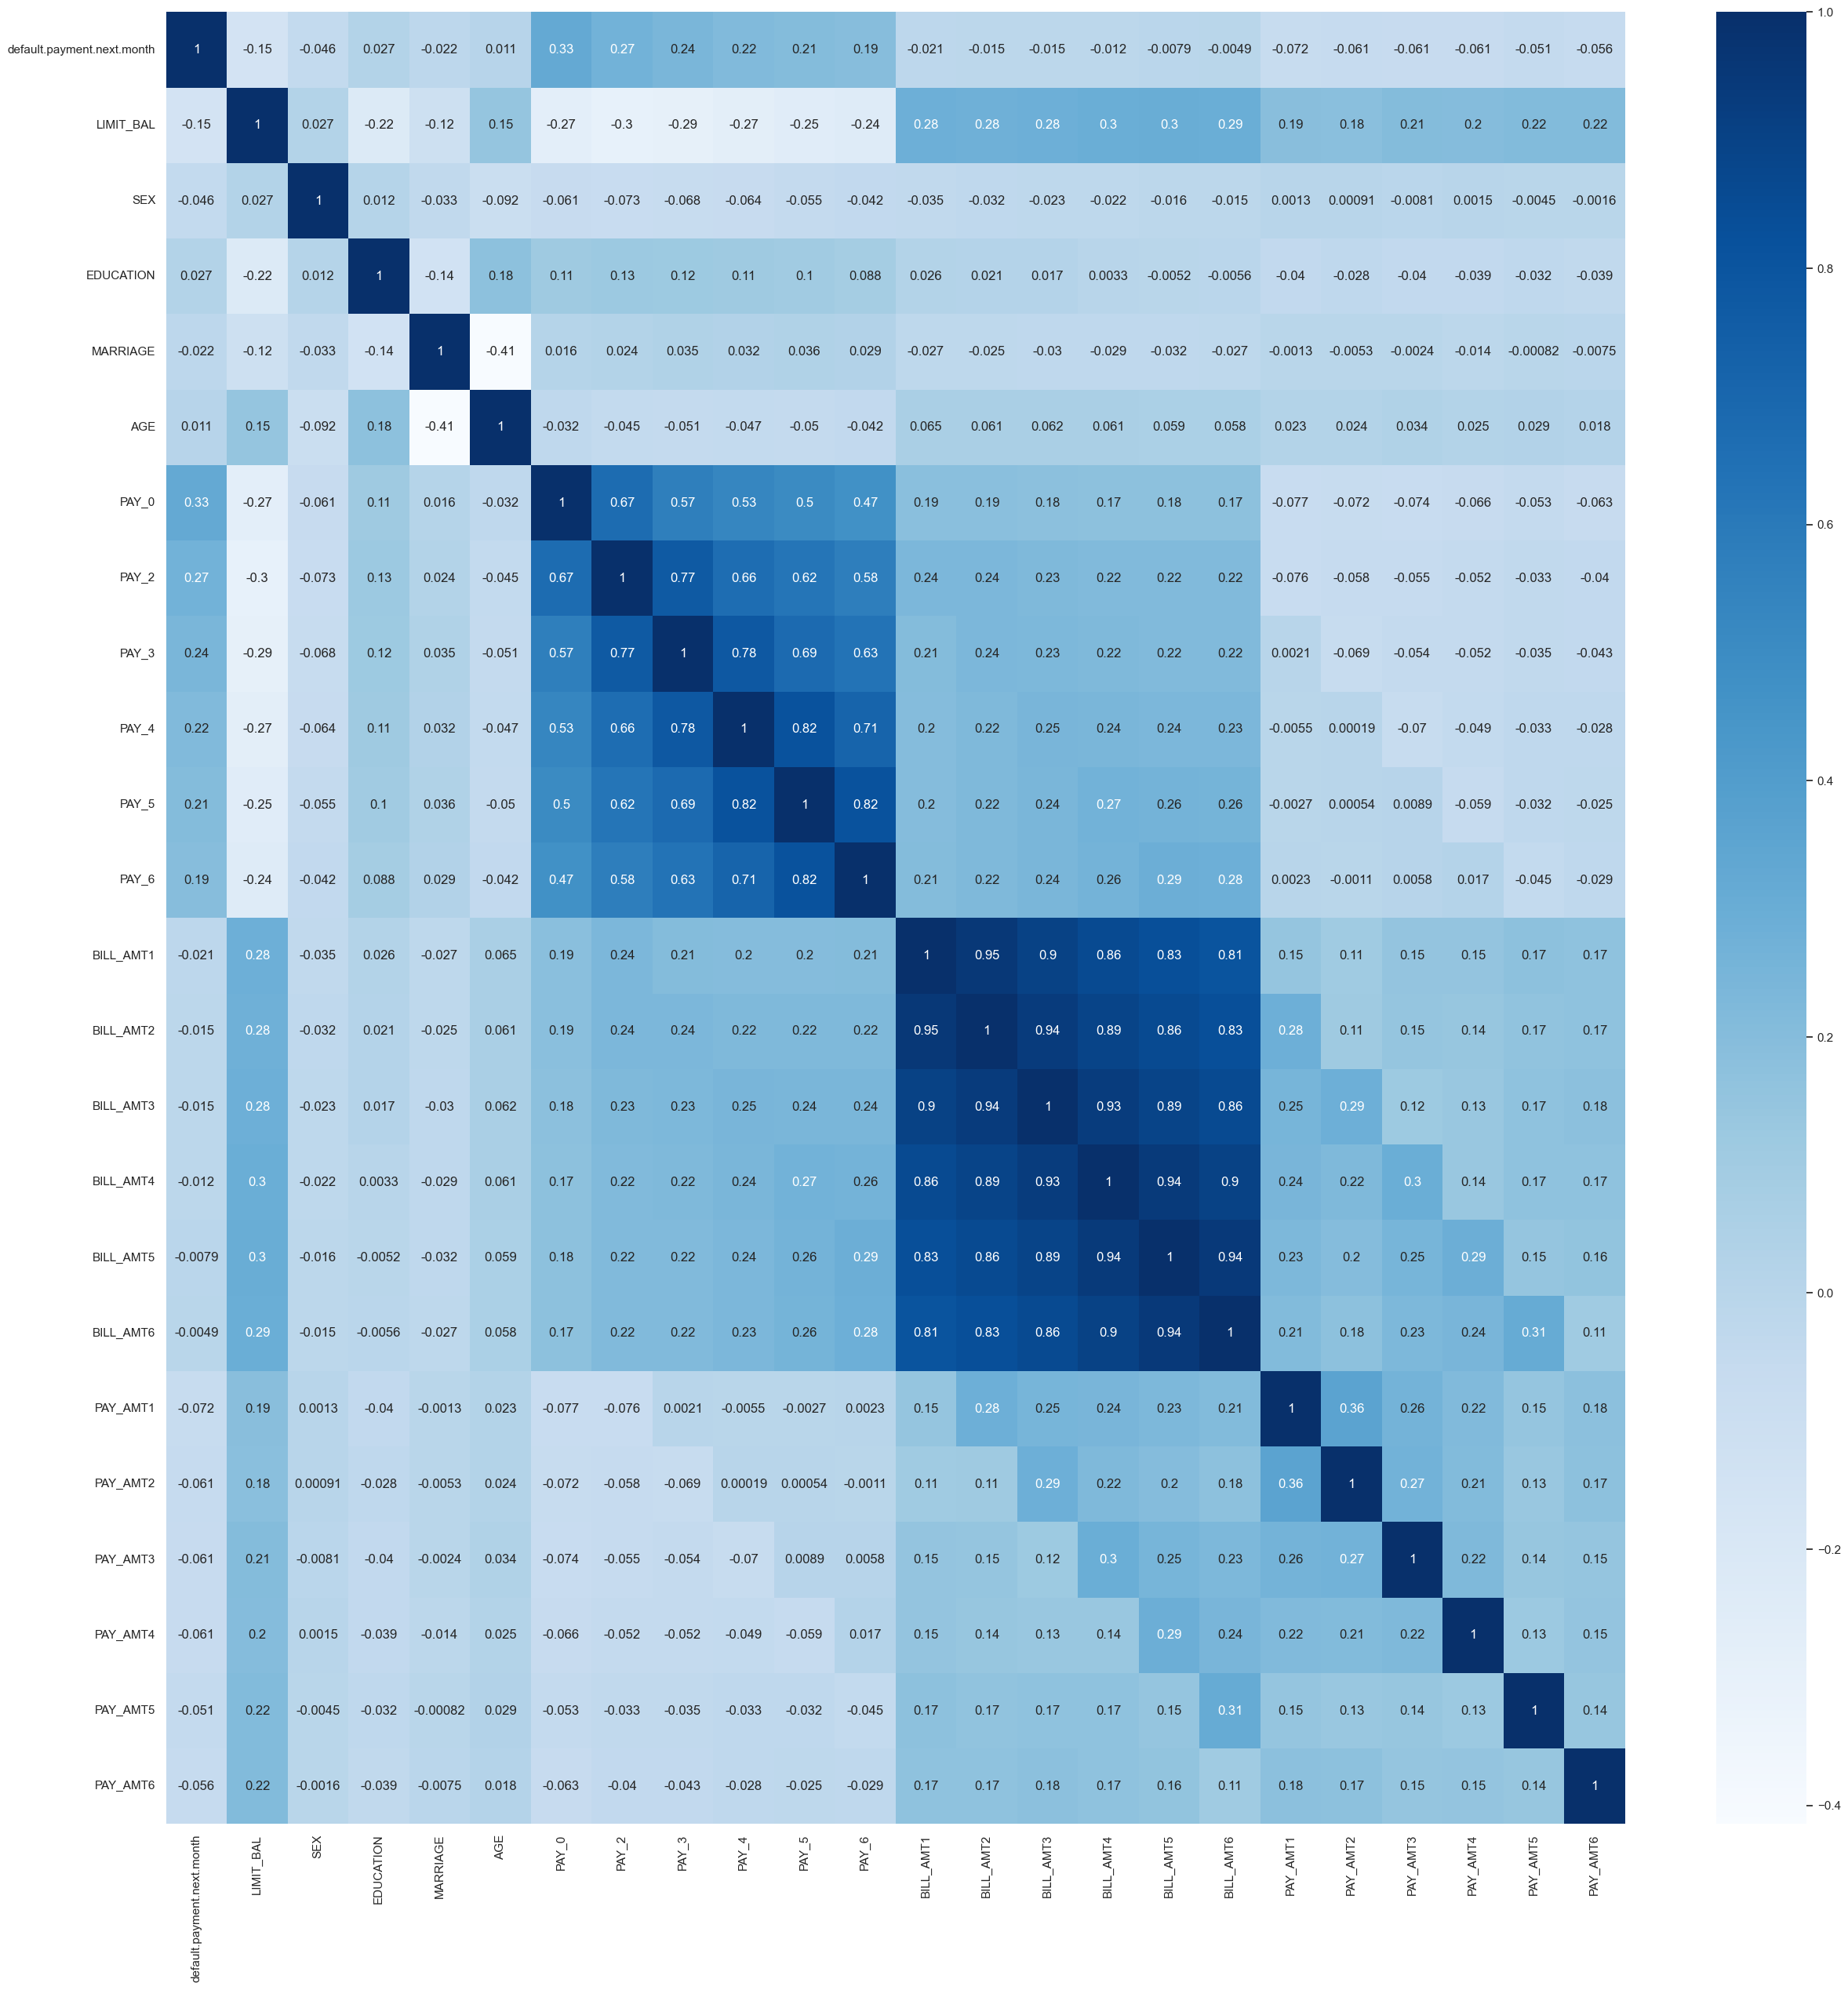

In [18]:
#Making a Heat Map
import seaborn as sns
cor = pd.concat((y_train, X_train), axis=1).iloc[:, :30].corr()
plt.figure(figsize=(30, 30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

Some initial observations:
    
- We have very few features.
- We have class imbalance and we need to deal with it. We have chosen macro average f1 as our target metric so that both classes get equal weight. 
- The feature ranges are very different, so we'll need to standardize. 
- We have a number of collinear features.
- We have quite a few outliers. 
- The data is messy / doesn't always correspond to the data description. 
  - What are education levels 5 and 6?
  - What does it mean for PAY_* to be -2? Or 0?

In [19]:
from sklearn.metrics import f1_score, make_scorer, recall_score

custom_scorer = make_scorer(f1_score, average="macro")
scoring_metric = custom_scorer

In [20]:
results = {}

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

None

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._
| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| LIMIT_BAL | StandardScaler | Need to set at same scale as others. |
| SEX | one-hot encoding with "binary=True" | since there is only male and female used in this dataset, complications of multiple columns can be avoided by using one-hot encoding (to numerize categorical variables) by setting binary = true so that one sex can one number or the other|
| AGE | scaling with `StandardScaler` |  Scaling is recommended due to its distinct range compared to other numeric features. While MinMaxScaler might be more suitable, using StandardScaler should be fine too.|
| EDUCATION | ordinal encoding | It makes sense to ordinally encode `EDUCATION` levels because it is first of all a categorical variable and also because a higher level of education is often times associated with a higher skillset learned which is reflected in one's personal ability.|
| MARRIAGE | one-hot encoding  | `MARRIAGE` uses one-hot encoding because it is first of all a categorical variable and it doesn't make sense to ordinally encode it because there is no certainty that one ranks over another (although there might be a possible association...) |
| PAY_N | Ordinal Encoding  | it is first of all a categorical variable and people that have paid duly should have a higher chance than people who pay late. |
| BILL_AMT | scaling with `StandardScaler` | At slightly different scales for each BILL AMT so use standard scaler to scale. | 
| PAY_AMT | scaling with `StandardScaler` | At slightly different scales for each BILL AMT so use standard scaler to scale. | 

In [21]:
# # Identifying the features
numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", 
                    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", "PAY_AMT1", 
                    "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
categorical_features = ["MARRIAGE"]
binary_features = ["SEX"]
education_features = ["EDUCATION"] 
pay_features= ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
drop_features = ["ID"]
# pay_features1 = ["PAY_0", "PAY_2", "PAY_3", "PAY_4"]
# pay_features2 =  ["PAY_5", "PAY_6"]
# passthrough_feats = ["ID"]  # do not apply any transformation

In [22]:
education_levels = ['0', '6', '5', '4', '3', '2', '1']
pay_levels = ['-2', '0', '-1', '1', '2', '3', '4', '5', '6', '7', '8']

In [23]:
# #making the transformers
numeric_transformer = StandardScaler()

ordinal_education = OrdinalEncoder(handle_unknown = "error", categories=[education_levels], dtype = int)

ordinal_pay = OrdinalEncoder(handle_unknown = "error", categories=[pay_levels, pay_levels, pay_levels, pay_levels, pay_levels, pay_levels], dtype = int)

binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=int)

In [24]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_education, education_features),
    (ordinal_pay, pay_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features)
)

In [25]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6']),
                                ('ordinalencoder-1',
                                 OrdinalEncoder(categories=[['0', '6', '5', '4',
                                                             '3', '2', '1']],
                                                dtype=<class 'int'>),
                                 ['EDUCATION']),
                                ('ordinalen...
                                                            ['-2', '0', '-1',
                                                             '1', '2', '3', '4',
                                                             '5', '6', '7',
                                                             '8'],
                                                            ['-2', '0', '-1',
                                                             '1', '2', '3', '4',
                                                             '5', '6', '7',
                                                             '8']],
                                                dtype=<class 'int'>),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['SEX']),
                                ('onehotencoder-2',
                                 OneHotEncoder(dtype=<class 'int'>,
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['MARRIAGE'])])

In [26]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
16395,320000.0,2,1,2,36,0,0,0,0,0,...,28695.0,19370.0,10155.0,3788.0,5000.0,5018.0,1000.0,3000.0,0.0,7013.0
21448,440000.0,2,1,2,30,-1,-1,-1,0,0,...,87426.0,171244.0,150897.0,117870.0,612.0,87426.0,130007.0,3018.0,15000.0,51663.0
20034,160000.0,2,3,1,44,-2,-2,-2,-2,-2,...,-18.0,-18.0,-18.0,-18.0,0.0,0.0,0.0,0.0,0.0,0.0
25755,120000.0,2,2,1,30,0,0,0,0,0,...,104694.0,103058.0,71095.0,47379.0,3706.0,5502.0,4204.0,3017.0,2005.0,1702.0
1438,50000.0,1,2,2,54,1,2,0,0,0,...,27168.0,27585.0,27910.0,27380.0,0.0,1400.0,1200.0,1500.0,1000.0,1500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000.0,2,2,1,37,0,0,0,0,0,...,13277.0,14291.0,15949.0,15556.0,1204.0,1300.0,1242.0,1900.0,0.0,3000.0
17730,360000.0,2,1,1,54,1,-2,-2,-1,0,...,0.0,2580.0,2580.0,6941.0,0.0,0.0,2580.0,0.0,6941.0,0.0
28030,50000.0,2,3,1,29,0,0,0,0,0,...,46777.0,39420.0,8824.0,9009.0,2002.0,2000.0,1530.0,1000.0,327.0,329.0
15725,30000.0,2,2,2,21,0,0,0,0,0,...,29435.0,30841.0,29434.0,16565.0,2000.0,2000.0,2000.0,1765.0,331.0,0.0


In [27]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out().tolist()
feature_names

['standardscaler__LIMIT_BAL',
 'standardscaler__AGE',
 'standardscaler__BILL_AMT1',
 'standardscaler__BILL_AMT2',
 'standardscaler__BILL_AMT3',
 'standardscaler__BILL_AMT4',
 'standardscaler__BILL_AMT5',
 'standardscaler__BILL_AMT6',
 'standardscaler__PAY_AMT1',
 'standardscaler__PAY_AMT2',
 'standardscaler__PAY_AMT3',
 'standardscaler__PAY_AMT4',
 'standardscaler__PAY_AMT5',
 'standardscaler__PAY_AMT6',
 'ordinalencoder-1__EDUCATION',
 'ordinalencoder-2__PAY_0',
 'ordinalencoder-2__PAY_2',
 'ordinalencoder-2__PAY_3',
 'ordinalencoder-2__PAY_4',
 'ordinalencoder-2__PAY_5',
 'ordinalencoder-2__PAY_6',
 'onehotencoder-1__SEX_2',
 'onehotencoder-2__MARRIAGE_0',
 'onehotencoder-2__MARRIAGE_1',
 'onehotencoder-2__MARRIAGE_2',
 'onehotencoder-2__MARRIAGE_3']

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [28]:
# Baseline model
dummy = DummyClassifier(strategy = "most_frequent", random_state = 123)
dummy

DummyClassifier(random_state=123, strategy='most_frequent')

In [29]:
pipe = make_pipeline(preprocessor, dummy)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['0',
                                                                              '6',
                                                                              '5',
                                                                              '4',
                                                                              '3',
                                                                              '2',
                                                                              '1']],
                                                                 dtype=<cl...
                                                                              '8']],
                                                                 dtype=<class 'int'>),
                                                  ['PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['SEX']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MARRIAGE'])])),
                ('dummyclassifier',
                 DummyClassifier(random_state=123, strategy='most_frequent'))])

In [30]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy
fit_time,0.005 (+/- 0.002)
score_time,0.002 (+/- 0.001)
test_score,0.501 (+/- 0.008)
train_score,0.499 (+/- 0.002)


In [31]:
cross_val_score(dummy, X_train, y_train)

array([0.65690476, 0.65047619, 0.65690476, 0.6547619 , 0.65809524])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

_I will be trying it out with a logistic regressor._

1. _see code_
2. _see code_
3. _see code_
4. _Looking at the CV scores, a C-value of 1 had the highest training score, cv score and a relatively low standard deviation. this C-value should be used if using a logistic regressor. The highest cv score was _

In [32]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced")
)
results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,dummy,logreg
fit_time,0.005 (+/- 0.002),0.152 (+/- 0.025)
score_time,0.002 (+/- 0.001),0.014 (+/- 0.001)
test_score,0.501 (+/- 0.008),0.672 (+/- 0.007)
train_score,0.499 (+/- 0.002),0.673 (+/- 0.003)


In [33]:
from scipy.stats import lognorm, loguniform, randint

param_grid = {"logisticregression__C": loguniform(1e-3, 1e3)}

random_search = RandomizedSearchCV(
    pipe_lr,
    param_grid,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
    refit = 'f1'
)

random_search.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [34]:
print("Best hyperparameter values: ", random_search.best_params_)
print("Best score: %0.3f" % (random_search.best_score_))

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'logisticregression__C': 0.0866469905214859}
Best score: 0.673


,mean_train_score,mean_test_score,param_logisticregression__C,mean_fit_time,std_test_score
rank_test_score,,,,,
1,0.673445,0.672934,0.086647,0.182463,0.006441
2,0.673139,0.672888,0.023420,0.143745,0.006667
3,0.673188,0.672810,0.031822,0.157903,0.006837
4,0.673144,0.672789,0.052100,0.131022,0.006461
5,0.673433,0.672757,0.244492,0.194600,0.006356
6,0.673321,0.672716,0.057847,0.168563,0.006467
7,0.673498,0.672676,0.114569,0.157300,0.005972
8,0.673187,0.672639,0.022967,0.120677,0.006765
9,0.673320,0.672594,0.080115,0.186648,0.006208


In [35]:
best_logreg = random_search.best_estimator_
results["logreg (tuned)"] = mean_std_cross_val_scores(
    best_logreg, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

_Models tested were the Random Forest, the decision tree, and the XGBoost tree. Default hyperparameters were used for these models because in the next question, you ask if they can be optimized._

_With the three models in their default hyperparameter settings, only XGBoost doesn't overfit. Overfitting is most notably seen in the decision tree and LGBM with a high train score but a low cv score. `max_depth` could be tuned for better results_


In [36]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1]
ratio

3.4795221843003414

In [37]:
#Random Forest
#Decision Tree Classifier
#XGBoost
models = {
    "random forest": RandomForestClassifier(class_weight="balanced", random_state=123),
    "decision tree": DecisionTreeClassifier(random_state=123),
    "xgboost": XGBClassifier(scale_pos_weight=ratio, random_state=123),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000)
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000)
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007)


In [38]:
...

Ellipsis

In [39]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

_I will use RFE to evaluate features. First I use `RFECV` to evaluate the number of features. I will attempt to use the logistic regression for this._




In [40]:
from sklearn.feature_selection import RFE, RFECV, SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [41]:
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000)
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000)
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007)
random forest+ feat_sel,5.856 (+/- 0.646),0.097 (+/- 0.002),0.671 (+/- 0.003),0.999 (+/- 0.000)
decision tree+ feat_sel,1.886 (+/- 0.239),0.018 (+/- 0.002),0.607 (+/- 0.016),0.999 (+/- 0.000)
xgboost+ feat_sel,2.074 (+/- 0.478),0.027 (+/- 0.003),0.681 (+/- 0.007),0.873 (+/- 0.003)


There was not much improvement with the feature selection.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

### Random Forest Tuning

In [42]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
}

pipe_rf = make_pipeline(preprocessor, models["random forest"])

In [43]:
random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_grid_rf,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6']),
                                                                              ('ordinalencoder-1',
                                                                               OrdinalEncoder(categories=[['0',
                                                                                                           '6',
                                                                                                           '5...
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6C656510>,
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6B2D91F0>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [44]:
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__n_estimators': 62}
Best score: 0.706


,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.796339,0.706379,62,11,1.895207,0.008789
2,0.776491,0.706294,35,10,1.074305,0.011481
3,0.757044,0.705647,76,9,2.012538,0.009377
4,0.819831,0.704396,67,12,2.284346,0.011817
5,0.820816,0.704357,79,12,3.198233,0.011881
6,0.796686,0.704072,42,11,1.317715,0.011503
7,0.741081,0.704069,95,8,2.320981,0.011347
8,0.821829,0.704063,32,12,1.204881,0.012984
9,0.726808,0.703991,96,7,2.189052,0.009720


In [45]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000)
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000)
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007)
random forest+ feat_sel,5.856 (+/- 0.646),0.097 (+/- 0.002),0.671 (+/- 0.003),0.999 (+/- 0.000)
decision tree+ feat_sel,1.886 (+/- 0.239),0.018 (+/- 0.002),0.607 (+/- 0.016),0.999 (+/- 0.000)
xgboost+ feat_sel,2.074 (+/- 0.478),0.027 (+/- 0.003),0.681 (+/- 0.007),0.873 (+/- 0.003)
random forest (tuned),2.046 (+/- 0.069),0.046 (+/- 0.003),0.706 (+/- 0.010),0.796 (+/- 0.003)


### Decision Tree Tuning

In [46]:
param_grid_dt = {
    "decisiontreeclassifier__max_depth": randint(1, 20),
    "decisiontreeclassifier__min_samples_split": randint(2, 20),
    "decisiontreeclassifier__min_samples_leaf": randint(1, 20),
    "decisiontreeclassifier__max_leaf_nodes": randint(2, 200)
}

pipe_dt = make_pipeline(preprocessor, models["decision tree"])
pipe_dt

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6']),
                                                 ('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['0',
                                                                              '6',
                                                                              '5',
                                                                              '4',
                                                                              '3',
                                                                              '2',
                                                                              '1']],
                                                                 dtype=<cl...
                                                                              '5',
                                                                              '6',
                                                                              '7',
                                                                              '8']],
                                                                 dtype=<class 'int'>),
                                                  ['PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['SEX']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['MARRIAGE'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=123))])

In [47]:
random_search_dt = RandomizedSearchCV(
    pipe_dt,
    param_grid_dt,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6']),
                                                                              ('ordinalencoder-1',
                                                                               OrdinalEncoder(categories=[['0',
                                                                                                           '6',
                                                                                                           '5...
                                        'decisiontreeclassifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6C181850>,
                                        'decisiontreeclassifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6B28F590>},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [48]:
print("Best hyperparameter values: ", random_search_dt.best_params_)
print("Best score: %0.3f" % (random_search_dt.best_score_))

pd.DataFrame(random_search_dt.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_decisiontreeclassifier__max_depth",
        "param_decisiontreeclassifier__min_samples_split",
        "param_decisiontreeclassifier__min_samples_leaf",
        "param_decisiontreeclassifier__max_leaf_nodes",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]


Best hyperparameter values:  {'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_leaf_nodes': 15, 'decisiontreeclassifier__min_samples_leaf': 13, 'decisiontreeclassifier__min_samples_split': 3}
Best score: 0.688


,mean_train_score,mean_test_score,param_decisiontreeclassifier__max_depth,param_decisiontreeclassifier__min_samples_split,param_decisiontreeclassifier__min_samples_leaf,param_decisiontreeclassifier__max_leaf_nodes,mean_fit_time,std_test_score
rank_test_score,,,,,,,,
1,0.691523,0.687640,8,3,13,15,0.180950,0.007668
2,0.688216,0.685997,14,8,15,10,0.197547,0.009130
3,0.688065,0.685049,7,8,15,11,0.197482,0.008664
4,0.690582,0.684701,7,3,11,19,0.196212,0.004235
5,0.687503,0.684632,3,19,18,39,0.119846,0.008481
5,0.687578,0.684632,3,11,6,163,0.121593,0.008481
7,0.692096,0.683911,11,6,14,24,0.200988,0.004223
8,0.689897,0.683017,13,3,18,20,0.200293,0.003395
9,0.684557,0.682864,3,5,12,5,0.134540,0.012161


In [49]:
best_dt_model = random_search_dt.best_estimator_
results["decision tree (tuned)"] = mean_std_cross_val_scores(
    best_dt_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000)
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000)
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007)
random forest+ feat_sel,5.856 (+/- 0.646),0.097 (+/- 0.002),0.671 (+/- 0.003),0.999 (+/- 0.000)
decision tree+ feat_sel,1.886 (+/- 0.239),0.018 (+/- 0.002),0.607 (+/- 0.016),0.999 (+/- 0.000)
xgboost+ feat_sel,2.074 (+/- 0.478),0.027 (+/- 0.003),0.681 (+/- 0.007),0.873 (+/- 0.003)
random forest (tuned),2.046 (+/- 0.069),0.046 (+/- 0.003),0.706 (+/- 0.010),0.796 (+/- 0.003)


In [50]:
param_grid_xgb = {
    "xgbclassifier__n_estimators": randint(10, 100),
    "xgbclassifier__max_depth": randint(low=2, high=20),
    "xgbclassifier__learning_rate": [0.01, 0.1],
    "xgbclassifier__subsample": [0.5, 0.75, 1],
}

pipe_xgb = make_pipeline(
    preprocessor,
    models["xgboost"],
)

In [51]:
random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_grid_xgb,
    n_iter=50,
    verbose=1,
    n_jobs=1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6']),
                                                                              ('ordinalencoder-1',
                                                                               OrdinalEncoder(categories=[['0',
                                                                                                           '6',
                                                                                                           '5...
                                        'xgbclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6D3C8050>,
                                        'xgbclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028D6D11C2F0>,
                                        'xgbclassifier__subsample': [0.5, 0.75,
                                                                     1]},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=1)

In [52]:
print("Best hyperparameter values: ", random_search_xgb.best_params_)
print("Best score: %0.3f" % (random_search_xgb.best_score_))

pd.DataFrame(random_search_xgb.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_xgbclassifier__max_depth",
        "param_xgbclassifier__n_estimators",
        "param_xgbclassifier__learning_rate",
        "param_xgbclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

Best hyperparameter values:  {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__n_estimators': 84, 'xgbclassifier__subsample': 0.5}
Best score: 0.704


,mean_train_score,mean_test_score,param_xgbclassifier__max_depth,param_xgbclassifier__n_estimators,param_xgbclassifier__learning_rate,param_xgbclassifier__subsample,mean_fit_time
rank_test_score,,,,,,,
1,0.793087,0.704044,10,84,0.01,0.50,0.662323
2,0.879512,0.702854,15,87,0.01,0.50,1.415841
3,0.875213,0.702645,15,76,0.01,0.50,1.510723
4,0.885067,0.702510,18,50,0.01,0.50,1.239423
5,0.862133,0.701593,12,75,0.01,0.75,1.176118
6,0.852118,0.701064,15,28,0.01,0.50,0.714395
7,0.737489,0.700784,7,66,0.01,0.50,0.282245
8,0.750007,0.700618,8,36,0.01,0.50,0.308701
9,0.934137,0.698383,16,97,0.01,0.75,2.185888


In [53]:
best_xgb_model = random_search_xgb.best_estimator_
results["xgb (tuned)"] = mean_std_cross_val_scores(
    best_xgb_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002)
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003)
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003)
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000)
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000)
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007)
random forest+ feat_sel,5.856 (+/- 0.646),0.097 (+/- 0.002),0.671 (+/- 0.003),0.999 (+/- 0.000)
decision tree+ feat_sel,1.886 (+/- 0.239),0.018 (+/- 0.002),0.607 (+/- 0.016),0.999 (+/- 0.000)
xgboost+ feat_sel,2.074 (+/- 0.478),0.027 (+/- 0.003),0.681 (+/- 0.007),0.873 (+/- 0.003)
random forest (tuned),2.046 (+/- 0.069),0.046 (+/- 0.003),0.706 (+/- 0.010),0.796 (+/- 0.003)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

_The SHAP summary plot quantifies the effect of each of the features. The one that stands out the most is the `PAY_0` which ranks the highest in importance. The results make sense as the less delay it takes to make a payment, the more tendency there is to fall under class 0, non default. `LIMIT BAL`'s plot makes sense as well because higher amounts of credit are typically given to those that will be less likely to default on payments. `EDUCATION` and `SEX` didn't seem to have much of an impact on importance as they didn't even make the list of the top 10 important features. `AGE` also didn't as shown with older and younger people just as likely to fall under either category._

In [54]:
import shap

preprocessor.fit(X_train, y_train)

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

,standardscaler__LIMIT_BAL,standardscaler__AGE,standardscaler__BILL_AMT1,standardscaler__BILL_AMT2,standardscaler__BILL_AMT3,standardscaler__BILL_AMT4,standardscaler__BILL_AMT5,standardscaler__BILL_AMT6,standardscaler__PAY_AMT1,standardscaler__PAY_AMT2,...,ordinalencoder-2__PAY_2,ordinalencoder-2__PAY_3,ordinalencoder-2__PAY_4,ordinalencoder-2__PAY_5,ordinalencoder-2__PAY_6,onehotencoder-1__SEX_2,onehotencoder-2__MARRIAGE_0,onehotencoder-2__MARRIAGE_1,onehotencoder-2__MARRIAGE_2,onehotencoder-2__MARRIAGE_3
16395,1.168355,0.054187,-0.300665,-0.293394,-0.265310,-0.371930,-0.494781,-0.587035,-0.039546,-0.040229,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
21448,2.090017,-0.597108,-0.685307,-0.679495,0.585444,1.970295,1.805461,1.327534,-0.297166,3.739796,...,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
20034,-0.060527,0.922579,-0.696132,-0.688319,-0.681234,-0.670935,-0.661045,-0.650908,-0.333097,-0.270403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25755,-0.367748,-0.597108,0.687456,0.752583,0.835581,0.918719,0.501203,0.144527,-0.115517,-0.018028,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
1438,-0.905384,2.008070,-0.040230,-0.031399,-0.287429,-0.245237,-0.204599,-0.191104,-0.333097,-0.206185,...,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [55]:
xgb_tuned = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=123,
    max_depth = random_search_xgb.best_params_["xgbclassifier__max_depth"],
    learning_rate=random_search_xgb.best_params_["xgbclassifier__learning_rate"],
    n_estimators=random_search_xgb.best_params_["xgbclassifier__n_estimators"],
    subsample=random_search_xgb.best_params_["xgbclassifier__subsample"],
)

xgb_tuned.fit(X_train_enc, y_train)
xgb_explainer = shap.TreeExplainer(xgb_tuned)
xgb_shap_values = xgb_explainer.shap_values(X_train_enc)

In [56]:
values = np.abs(xgb_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
standardscaler__LIMIT_BAL,0.040376
standardscaler__AGE,0.040376
onehotencoder-2__MARRIAGE_2,0.040376
onehotencoder-2__MARRIAGE_1,0.040376
onehotencoder-2__MARRIAGE_0,0.040376
onehotencoder-1__SEX_2,0.040376
ordinalencoder-2__PAY_6,0.040376
ordinalencoder-2__PAY_5,0.040376
ordinalencoder-2__PAY_4,0.040376
ordinalencoder-2__PAY_3,0.040376


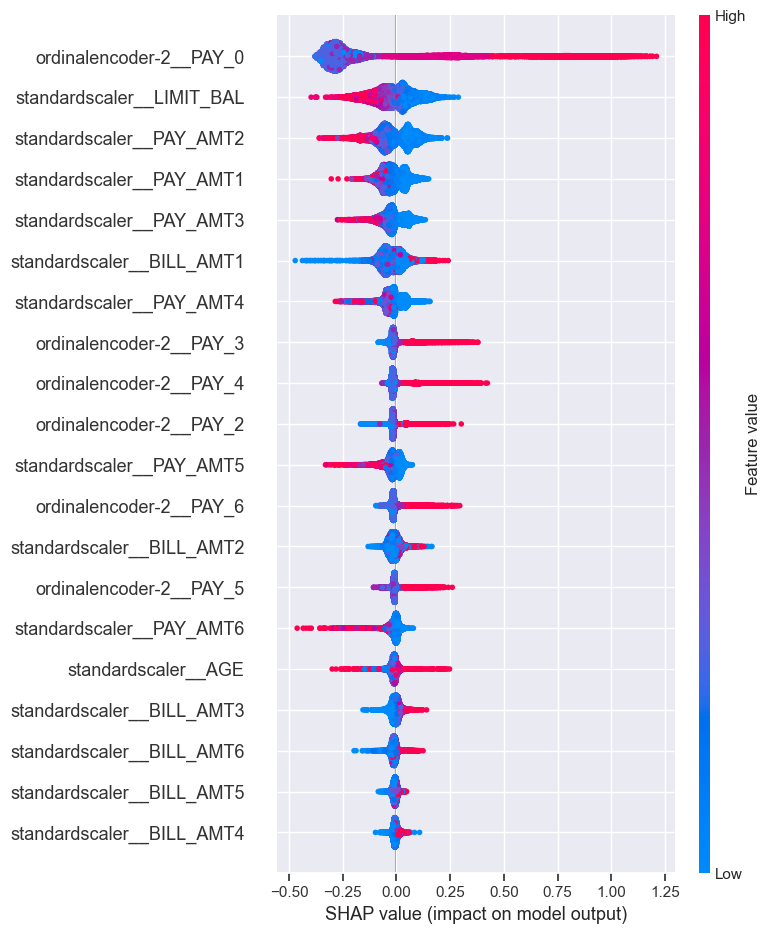

In [57]:
shap.summary_plot(xgb_shap_values, X_train_enc)

In [58]:
...

Ellipsis

In [59]:
...

Ellipsis

In [60]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

2. _The test scores agree with the validation scores (69.5% vs 70.4%). I trust the results because the model doesn't overfit and the small difference between test and validation scores indicate no issues with optimization bias._
3. _For prediction of non default: the raw score of -0.53 is smaller than the base value of 0.02 so the prediction would be non default._
   _For prediction of default: the raw score of 1.03 is greater than the base value of 0.02 so the prediction would be that the user defaults_

In [61]:
from sklearn.metrics import f1_score

best_model = random_search_xgb.best_estimator_
print(
    "Grid Search best model validation score: %0.3f" % (random_search_xgb.best_score_)
)

predictions = best_model.predict(X_test)
print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, predictions, average="macro"))
)

Grid Search best model validation score: 0.704
Macro-average f1 score on the test set: 0.695


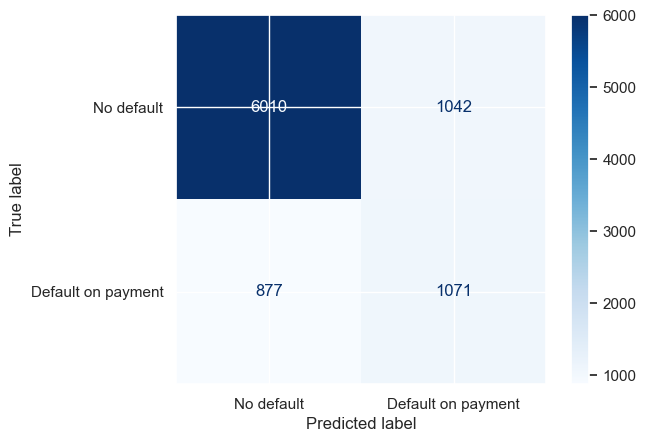

In [62]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=["No default", "Default on payment"],
    values_format="d",
    cmap=plt.cm.Blues,
)

In [63]:
print(
    classification_report(
        y_test, predictions, target_names=["No default", "Default on payment"]
    )
)

                    precision    recall  f1-score   support

        No default       0.87      0.85      0.86      7052
Default on payment       0.51      0.55      0.53      1948

          accuracy                           0.79      9000
         macro avg       0.69      0.70      0.69      9000
      weighted avg       0.79      0.79      0.79      9000



In [64]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

test_xgb_shap_values = xgb_explainer.shap_values(X_test_enc)

In [65]:
y_test_reset = y_test.reset_index(drop=True)
non_default_ind = y_test_reset[y_test_reset == 0].index.tolist()
default_ind = y_test_reset[y_test_reset == 1].index.tolist()

ex_non_default_index = non_default_ind[0]
ex_default_index = default_ind[0]

In [66]:
xgb_tuned.predict_proba(X_test_enc)[ex_non_default_index]

array([0.6291907 , 0.37080935], dtype=float32)

In [67]:
xgb_tuned.predict(X_test_enc, output_margin = True)[1]

-0.54432636

In [68]:
xgb_explainer.expected_value

0.02425888

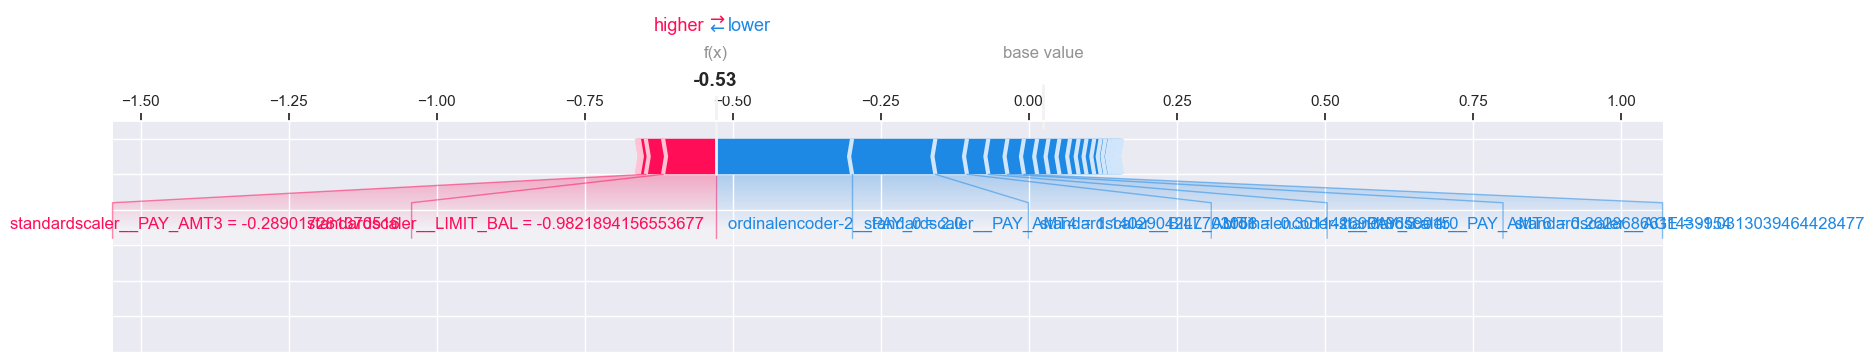

In [69]:
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[ex_non_default_index, :],
    X_test_enc.iloc[ex_non_default_index, :],
    matplotlib=True,
)

In [70]:
xgb_tuned.predict_proba(X_test_enc)[ex_default_index]

array([0.26278943, 0.7372106 ], dtype=float32)

In [71]:
xgb_tuned.predict(X_test_enc, output_margin = True)[ex_default_index]

1.0315206

In [72]:
xgb_explainer.expected_value

0.02425888

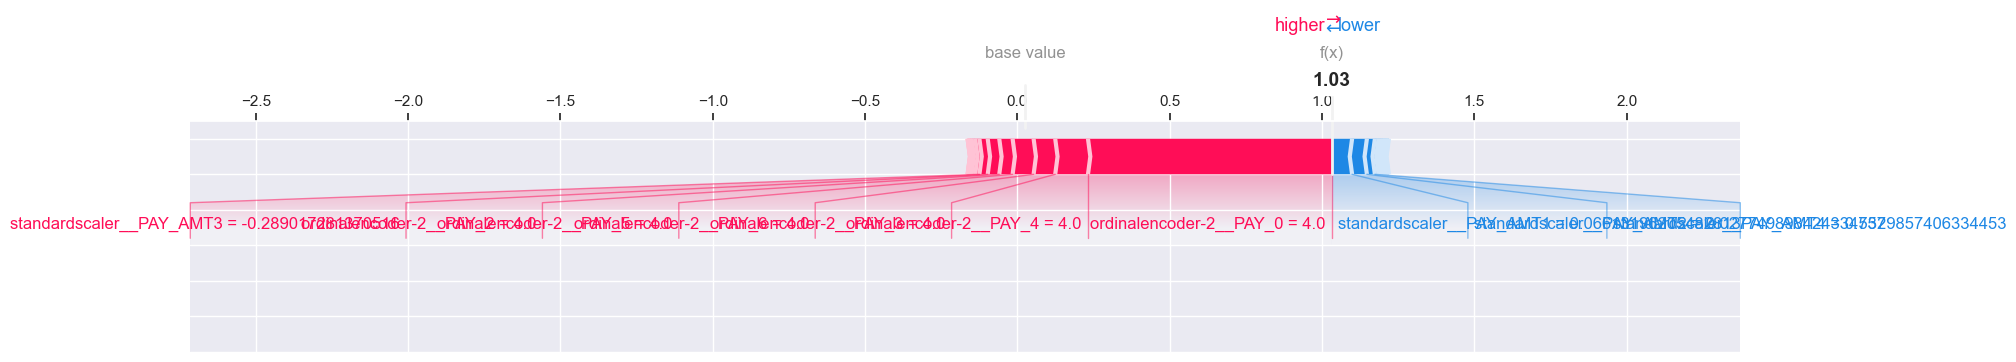

In [73]:
shap.force_plot(
    xgb_explainer.expected_value,
    test_xgb_shap_values[ex_default_index, :],
    X_test_enc.iloc[ex_default_index, :],
    matplotlib=True,
)

In [74]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [75]:
pd.DataFrame(results).T
summary_df = pd.DataFrame(results).T

In [76]:
comments = {
    "dummy": "Baseline of 0.50 macro-average f1 score.",
    "logreg": "Improvement over the baseline but underfitting.",
    "logreg (tuned)": "Slight improvement but still underfitting.",
    "random forest": "Improvement over tuned logistic regression but overfitting.",
    "decision tree": "Worse than Logisitc Regression as well as overfitting",
    "xgboost": "Best results so far and less overfitting compared to random forest.",
    "random forest+ feat_sel": "Feature selection with L1 regularization helps a tiny bit.",
    "xgboost+ feat_sel": "No Improvement",
    "decision tree+ feat_sel": "No improvement.",
    "random forest (tuned)": "Hyperparameter optimization helped. Best results overall! The scores are very similar to random forest scores but picking this as the best model for its speed.",
    "decision tree (tuned)": "Significant improvement but not much better than Logisitc Regression",
    "xgb (tuned)": "Hyperparameter optimization helped!",
}
pd.set_option("display.max_colwidth", 0)
summary_df["comments"] = comments.values()
summary_df

,fit_time,score_time,test_score,train_score,comments
dummy,0.005 (+/- 0.002),0.002 (+/- 0.001),0.501 (+/- 0.008),0.499 (+/- 0.002),Baseline of 0.50 macro-average f1 score.
logreg,0.152 (+/- 0.025),0.014 (+/- 0.001),0.672 (+/- 0.007),0.673 (+/- 0.003),Improvement over the baseline but underfitting.
logreg (tuned),0.202 (+/- 0.027),0.018 (+/- 0.002),0.673 (+/- 0.007),0.673 (+/- 0.003),Slight improvement but still underfitting.
random forest,4.618 (+/- 0.069),0.099 (+/- 0.008),0.669 (+/- 0.004),0.999 (+/- 0.000),Improvement over tuned logistic regression but overfitting.
decision tree,0.415 (+/- 0.007),0.018 (+/- 0.002),0.609 (+/- 0.014),0.999 (+/- 0.000),Worse than Logisitc Regression as well as overfitting
xgboost,0.565 (+/- 0.614),0.023 (+/- 0.002),0.683 (+/- 0.011),0.875 (+/- 0.007),Best results so far and less overfitting compared to random forest.
random forest+ feat_sel,5.856 (+/- 0.646),0.097 (+/- 0.002),0.671 (+/- 0.003),0.999 (+/- 0.000),Feature selection with L1 regularization helps a tiny bit.
decision tree+ feat_sel,1.886 (+/- 0.239),0.018 (+/- 0.002),0.607 (+/- 0.016),0.999 (+/- 0.000),No Improvement
xgboost+ feat_sel,2.074 (+/- 0.478),0.027 (+/- 0.003),0.681 (+/- 0.007),0.873 (+/- 0.003),No improvement.
random forest (tuned),2.046 (+/- 0.069),0.046 (+/- 0.003),0.706 (+/- 0.010),0.796 (+/- 0.003),Hyperparameter optimization helped. Best results overall! The scores are very similar to random forest scores but picking this as the best model for its speed.


<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

- Data cleaning is essential
- Lots of experimentation must be done with models
- Hyperparameter tuning helps tremendously. 

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)